In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 dayfirst=True,
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)

/var/folders/s3/7tk7hl2j6gz63rsgbp_4ctvm0000gn/T/ipykernel_21034/2702773909.py:1: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv('household_power_consumption.txt',
/var/folders/s3/7tk7hl2j6gz63rsgbp_4ctvm0000gn/T/ipykernel_21034/2702773909.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('household_power_consumption.txt',


In [3]:
df = df.dropna()

In [4]:
df['Global_active_power'] = df['Global_active_power'].astype(float)

In [5]:
df = df.set_index('datetime')

In [6]:
import os

from groq import Groq

In [7]:
from dotenv import load_dotenv

load_dotenv()
groq_api_key = os.getenv("Groq_API_Key")

In [8]:
client = Groq(
    api_key = groq_api_key,
)

In [9]:
# Prompt template for generating python code

GENERATION_PROMPT_TEMPLATE = """
# CONTEXT
# You have a pandas DataFrame named df,
# Dataframe df is indexed by datetime, with columns:
# ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
#  'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# DataFrame columns description:
# `Global_active_power` - minute averaged active power (in kilowatt)
# `Global_reactive_power` - minute averaged active power (in kilowatt)
# `Voltage` - minute averaged voltage (in volt) 
# `Global_intensity` - minute averaged current intensity(in ampere)
# `Sub_metering_1` (in watt-hour of active energy)
# `Sub_metering_2` (in watt-hour of active energy)
# `Sub_metering_3` (in watt-hour of active energy)

# INSTRUCTIONS
# - Generate only valid executable Python code (no explanations or markdown ).
# - Include all necessary imports (e.g., pandas, matplotlib).
# - Assume df is already loaded and preprocessed.

# EXAMPLES
# Query: What was the average active power in January 2007?
# Python Code:
# import pandas as pd
# avg_jan = df.loc['2007-01-01':'2007-01-31']['Global_active_power'].mean()
# print(avg_jan)
# 
# Query: What was the maximum voltage on February 1, 2007?
# Python Code:
# import pandas as pd
# max_vol = df['2007-02-01']['Voltage'].max()
# 
# Query: Plot voltage values for February 2, 2007
# Python Code:
# import matplotlib.pyplot as plt
# voltage_day = df.loc['2007-02-02']['Voltage']
# voltage_day.plot()
# plt.title("Voltage on 2007-02-02")
# plt.xlabel("Time")
# plt.ylabel("Voltage (V)")
# plt.show()
# 

# NOW GENERATE CODE
# Query: {query}
# 

"""

In [10]:
# Prompt template for validating python code

VALIDATION_PROMPT_TEMPLATE = """
# CONTEXT
# The following pandas code snippet is intended to answer the question:
# "{query}" against the DataFrame df.

# CODE_SNIPPET_START
{code}
# CODE_SNIPPET_END

# TASK
# - Verify that the snippet correctly uses pandas operations to fulfill the query.
# - Return ONLY 'VALID' if correct, or 'INVALID: ' plus a brief correction hint.
"""

In [11]:
refine_prompt = """
# TASK: The following pandas code for query "{query}" is INVALID. Correct it.
# ORIGINAL_CODE_START
{code}
# ORIGINAL_CODE_END

# CORRECT GENERATE CODE
# Q: {query}
# ```python

# Return only the corrected Python snippet without commentary.
"""


In [12]:
def generate_code(query:str)->str:
    """Generate pandas code for a given natural-language query."""
    prompt = GENERATION_PROMPT_TEMPLATE.format(query = query)
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {
                "role": "system",
                "content": prompt,
            }
        ],
        temperature = 0.1
    )
    return response.choices[0].message.content.strip()

In [13]:
def validate_code(query: str, code: str) -> str:
    """Validate a generated pandas code snippet via the LLM."""
    prompt = VALIDATION_PROMPT_TEMPLATE.format(query=query, code=code)
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {
                "role": "system",
                "content": prompt
            }
        ],
        temperature=0.1,
    )
    return response.choices[0].message.content.strip()

In [14]:
def refine_code(query: str, code: str) -> str:
    """Refine an invalid code snippet to be correct."""
    prompt = refine_prompt.format(query=query, code=code)
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {
                "role": "system",
                "content": prompt
            }
        ],
        temperature=0.0,
        max_tokens=256,
    )
    return response.choices[0].message.content.strip()

In [15]:
queries = ['What was the average active power consumption in March 2007?',
           'What hour of the day had the highest power usage on Christmas 2006?',
           'Compare energy usage (Global_active_power) on weekdays vs weekends.',
           'Find days where energy consumption exceeded 5 kWh.',
           'Plot the energy usage trend for the first week of January 2007.',
           'Find the average voltage for each day of the first week of February 2007.',
           'What is the correlation between global active power and sub-metering values?']

In [16]:
llm_resoponses = []
for idx, query in enumerate(queries, start=1):
    code = generate_code(query)
    validation = validate_code(query, code)
    
    # if response is invalid, refining it once
    if not validation.startswith('VALID'):
        code = refine_code(query, code)
        validation = validate_code(query, code)
        llm_resoponses.append(code)
    
    if validation.startswith('VALID'):
        print(f"Query-{idx}:{query}\n Generated code:\n {code}\n")
        llm_resoponses.append(code)
    else:
        print(f"Failed to produce valid code for query {idx}: \n{validation}")


Query-1:What was the average active power consumption in March 2007?
 Generated code:
 import pandas as pd
avg_mar = df.loc['2007-03-01':'2007-03-31']['Global_active_power'].mean()
print(avg_mar)

Query-2:What hour of the day had the highest power usage on Christmas 2006?
 Generated code:
 import pandas as pd

# Filter data for Christmas 2006
christmas_2006 = df.loc['2006-12-25']

# Resample data by hour and calculate mean power usage
hourly_power = christmas_2006.resample('H')['Global_active_power'].mean()

# Find the hour with the highest power usage
max_power_hour = hourly_power.idxmax()

print(max_power_hour)

Query-3:Compare energy usage (Global_active_power) on weekdays vs weekends.
 Generated code:
 import pandas as pd
import matplotlib.pyplot as plt

# Create a column 'day_of_week' in the dataframe
df['day_of_week'] = df.index.dayofweek

# Create two separate dataframes for weekdays and weekends
weekdays = df[df['day_of_week'] < 5]
weekends = df[df['day_of_week'] >= 5]

# Calcu

Query:What was the average active power consumption in March 2007?
Code Output:
1.3186270301754073


Query:What hour of the day had the highest power usage on Christmas 2006?
Code Output:
2006-12-25 22:00:00


Query:Compare energy usage (Global_active_power) on weekdays vs weekends.
Code Output:


<string>:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.


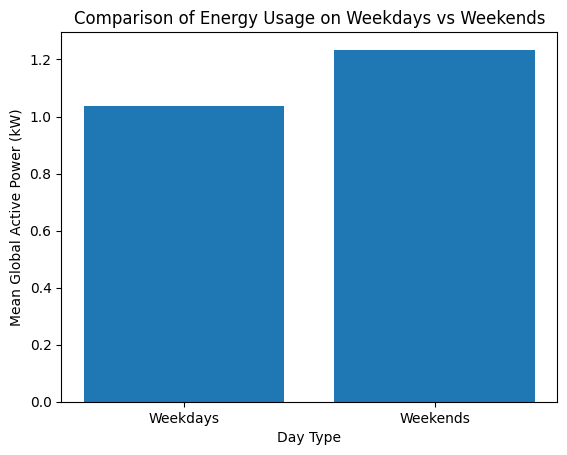



Query:Find days where energy consumption exceeded 5 kWh.
Code Output:
An error occurred during execution of query: {'Find days where energy consumption exceeded 5 kWh.'}

 Error: 'numpy.ndarray' object has no attribute 'unique'
Query:Plot the energy usage trend for the first week of January 2007.
Code Output:


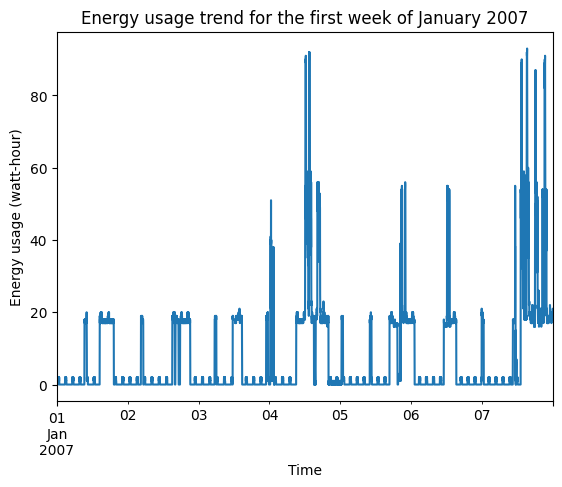



Query:Find the average voltage for each day of the first week of February 2007.
Code Output:
datetime
2007-02-01    240.392139
2007-02-02    240.334389
2007-02-03    238.910194
2007-02-04    239.633333
2007-02-05    240.810312
2007-02-06    241.264160
2007-02-07    241.149694
Freq: D, Name: Voltage, dtype: float64


Query:What is the correlation between global active power and sub-metering values?
Code Output:
Sub_metering_1    0.484401
Sub_metering_2    0.434569
Sub_metering_3    0.638555
Name: Global_active_power, dtype: float64




In [17]:
#Executing code generated by llm
for query, code in zip(queries,llm_resoponses):
    try:
        print(f"Query:{query}")
        print("Code Output:")
        exec(code)
        print("\n")
    except Exception as e:
        print("An error occurred during execution of query:",{query})
        print("\n Error:", str(e))